# Evaluating Bot Performance (Chess)

In [1]:
import os
import numpy as np
import seaborn as sb
from datetime import timedelta
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

parent = '/'.join(s for s in os.getcwd().split('/')[:-1])
print(parent)

/Users/benbellerose/Documents/GitHub/chappie.ai


In [2]:
import pandas as pd

ai = 'test_v9'

game_df = pd.read_csv(f'{parent}/skills/chess/data/models/{ai}/logs/game_log.csv')
game_df.head(5)

,state0,state1,state2,state3,state4,state5,state6,state7,state8,state9,...,prob4093,prob4094,prob4095,action,time,value,reward,ELO,Game-ID,Date
0,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,3437.0,1.299585,-1.0,0.0,NaN,6FV4BB6AQJZ6D2E,2022-04-08 14:35:10.055492
1,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,853.0,1.304346,1.0,0.0,NaN,6FV4BB6AQJZ6D2E,2022-04-08 14:35:10.055492
2,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,3559.0,1.352560,-1.0,0.0,NaN,6FV4BB6AQJZ6D2E,2022-04-08 14:35:10.055492
3,1.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,788.0,1.318108,1.0,0.0,NaN,6FV4BB6AQJZ6D2E,2022-04-08 14:35:10.055492
4,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,9.0,...,0.0,0.0,0.0,4079.0,1.321986,-1.0,0.0,NaN,6FV4BB6AQJZ6D2E,2022-04-08 14:35:10.055492


## Game Play

In [3]:
def parse_move(move):
    x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
    y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation
    b_a = int(move['action'])
    a_map = np.zeros(4096)
    a_map[b_a] = 1
    a_map = a_map.reshape((8,8,8,8))
    a_index = [(cy, cx, ny, nx) for cy, cx, ny, nx in zip(*np.where(a_map == 1))][0]
    c_p = f'{x_map[a_index[1]]}{y_map[a_index[0]]}'
    n_p = f'{x_map[a_index[3]]}{y_map[a_index[2]]}'
    return (c_p, n_p)

In [4]:
play_time = game_df['time'].sum()

print('Total Play Time')
print('---------------')
print(f'{ai} = {timedelta(seconds=play_time)}')

Total Play Time
---------------
test_v9 = 1 day, 20:49:17.530606


### Win Distribution

Knowing the win distrabution helps know how balanced our training data is being.

In [5]:
results = []
for g, g_df in game_df.groupby('Game-ID'):
    results.append({'game':g, 'result':g_df.iloc[0]['value'], 'duration':len(g_df)})
results = pd.DataFrame(results)
print(f'Total Games Played = {len(results)}')
results['result'].value_counts(normalize=True).to_frame().T

Total Games Played = 448


,-1.0,1.0,0.0
result,0.455357,0.410714,0.133929


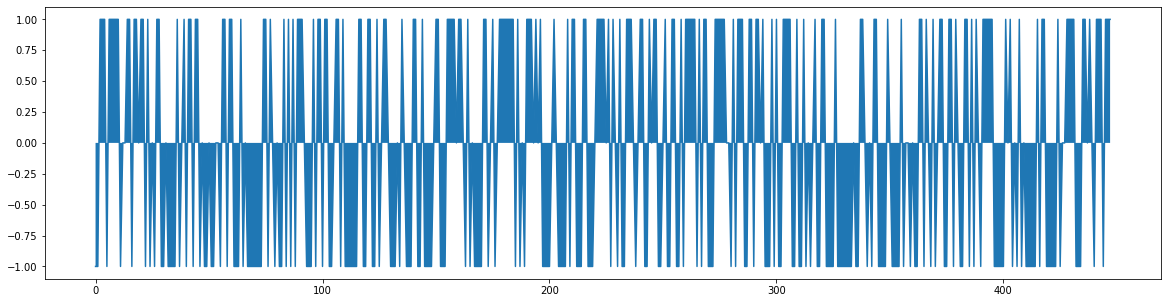

In [6]:
results['result'].plot.line(figsize=(20, 5), legend=False)
plt.fill_between(results.index,results['result'])
plt.show()

### Game Duration

<AxesSubplot:>

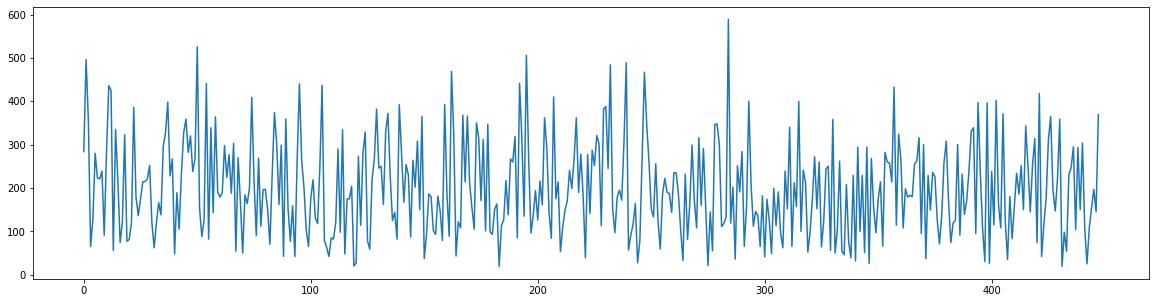

In [7]:
results['duration'].plot.line(figsize=(20, 5), legend=False)

### Move Distribution

In [8]:
x_map = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h'] #Board x representation
y_map = ['8', '7', '6', '5', '4', '3', '2', '1'] #Board y representation

o_results = []
for g, g_log in game_df.dropna(subset=['ELO']).groupby('Game-ID'):
    move = 1
    for i, row in g_log.iterrows():
        c_pos, n_pos = parse_move(row)
        o_results.append({
            'x': x_map.index(n_pos[0]), 
            'y':y_map.index(n_pos[1]),
            'z':move, 
            'c':-1 if (move % 2) == 0 else 1
        })
        move += 1
o_results = pd.DataFrame(o_results)

### White Player Move Distribution

In [9]:
w_results = o_results[o_results['c']==1]
w_m_count_df = []
for m, m_df in w_results.groupby('z'):
    m_hold = {}
    for i, row in m_df.iterrows():
        board = np.zeros((8,8))
        board[row['y']][row['x']] = 1
        board = board.reshape((64))
        flat_pos = np.where(board == 1)[0][0]
        if flat_pos in m_hold:
            m_hold[flat_pos] += 1
        else:
            m_hold[flat_pos] = 1
    for x in range(64):
        w_m_count_df.append({
            'x':x,
            'y':m,
            'z':m_hold[x] if x in m_hold else 0
        })
    
w_m_count_df = pd.DataFrame(w_m_count_df).fillna(0)

Text(0.5, 0, 'action occurrence')

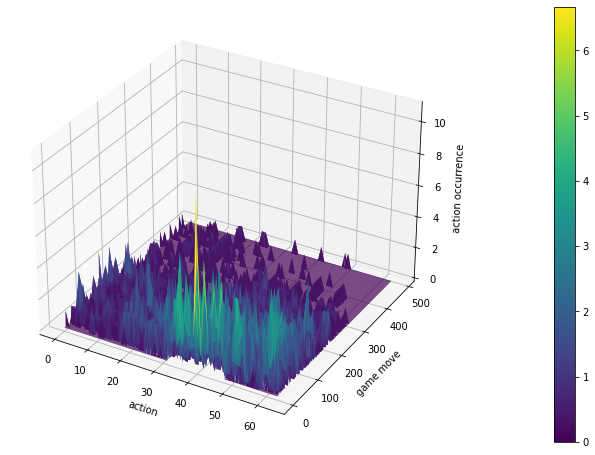

In [10]:
plt.rcParams['figure.figsize'] = (40,8)

ax = plt.axes(projection='3d')
plot3D = ax.plot_trisurf(w_m_count_df['x'], w_m_count_df['y'], w_m_count_df['z'], cmap='viridis', linewidth=0.5)

cb = plt.colorbar(plot3D)

ax.set_xlabel('action')
ax.set_ylabel('game move')
ax.set_zlabel('action occurrence')

### Black Player Move Distribution

In [11]:
b_results = o_results[o_results['c']==-1]
b_m_count_df = []
for m, m_df in b_results.groupby('z'):
    m_hold = {}
    for i, row in m_df.iterrows():
        board = np.zeros((8,8))
        board[row['y']][row['x']] = 1
        board = board.reshape((64))
        flat_pos = np.where(board == 1)[0][0]
        if flat_pos in m_hold:
            m_hold[flat_pos] += 1
        else:
            m_hold[flat_pos] = 1
    for x in range(64):
        b_m_count_df.append({
            'x':x,
            'y':m,
            'z':m_hold[x] if x in m_hold else 0
        })
    
b_m_count_df = pd.DataFrame(b_m_count_df).fillna(0)

Text(0.5, 0, 'action occurrence')

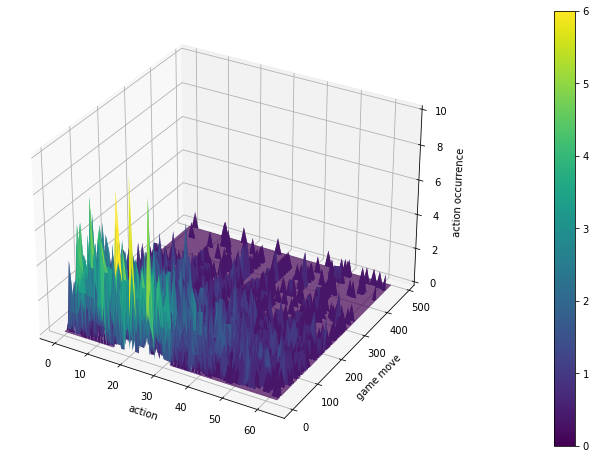

In [12]:
plt.rcParams['figure.figsize'] = (40,8)

ax = plt.axes(projection='3d')
plot3D = ax.plot_trisurf(b_m_count_df['x'], b_m_count_df['y'], b_m_count_df['z'], cmap='viridis', linewidth=0.5)

cb = plt.colorbar(plot3D)

ax.set_xlabel('action')
ax.set_ylabel('game move')
ax.set_zlabel('action occurrence')

### White Opening Moves

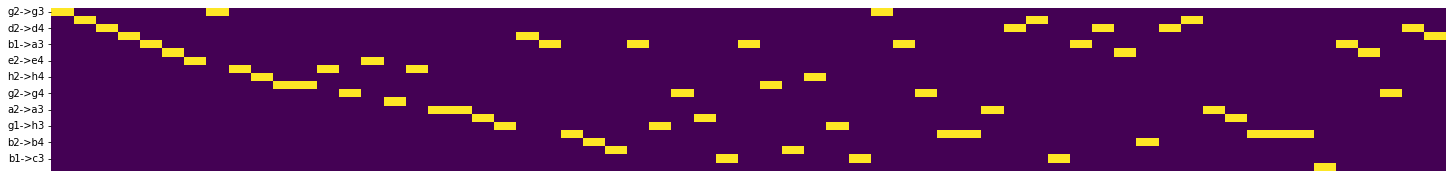

In [13]:
o_results = []
for g, g_log in game_df.dropna(subset=['ELO']).groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[0])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Black Opening Moves

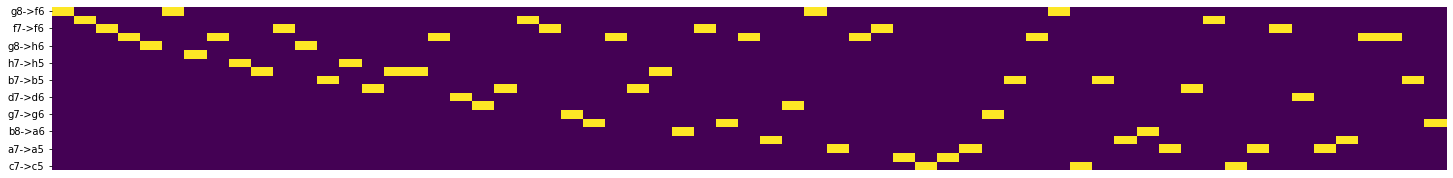

In [14]:
o_results = []
for g, g_log in game_df.dropna(subset=['ELO']).groupby('Game-ID'):
    c_pos, n_pos = parse_move(g_log.iloc[1])
    o_results.append({f'{c_pos}->{n_pos}':1})
o_results = pd.DataFrame(o_results).fillna(0).T

plt.rcParams['figure.figsize'] = [25, 3] #Resize graph 
sb.heatmap(o_results, cmap='viridis', cbar=False, xticklabels=False, linewidths=0)
plt.show()

### Game Action Probabilities

In [15]:
'''
p_headers = [h for h in game_df if 'prob' in h]

a_probs = []
for i, row in game_df[p_headers].iterrows():
    a_probs.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})

a_probs = pd.DataFrame(a_probs)
plt.rcParams['figure.figsize'] = [25, 5] #Resize graph 
sb.heatmap(a_probs.T, cmap='magma', xticklabels=False, linewidths=0)
plt.show()
'''

"\np_headers = [h for h in game_df if 'prob' in h]\n\na_probs = []\nfor i, row in game_df[p_headers].iterrows():\n    a_probs.append({k.replace('prob',''):v for k, v in row[(row > 0)].to_dict().items()})\n\na_probs = pd.DataFrame(a_probs)\nplt.rcParams['figure.figsize'] = [25, 5] #Resize graph \nsb.heatmap(a_probs.T, cmap='magma', xticklabels=False, linewidths=0)\nplt.show()\n"

### Game Tree

In [16]:
'''
s_headers = [h for h in game_df if 'state' in h]
p_headers = [h for h in game_df if 'prob' in h]

tree = {}
for i, row in game_df.iterrows():
    s_hash = hash(str(row[s_headers].tolist()))
    tree[(s_hash)] = 
    break
print(tree)


import matplotlib.pyplot as plt
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

G = nx.Graph()
for s in search.tree:
    for a in search.tree[s].n_s:
        G.add_edge(s,a)
        
pos = graphviz_layout(G, prog='dot')
#Display network graph -----------------------------
nx.draw(
    G, #Graph nodes & connections
    pos, #Position of graph
    with_labels=True #Labels on nodes
)
plt.rcParams['figure.figsize'] = [40, 40] #Resize graph
plt.show()
'''

"\ns_headers = [h for h in game_df if 'state' in h]\np_headers = [h for h in game_df if 'prob' in h]\n\ntree = {}\nfor i, row in game_df.iterrows():\n    s_hash = hash(str(row[s_headers].tolist()))\n    tree[(s_hash)] = \n    break\nprint(tree)\n\n\nimport matplotlib.pyplot as plt\nimport networkx as nx\nimport pydot\nfrom networkx.drawing.nx_pydot import graphviz_layout\n\nG = nx.Graph()\nfor s in search.tree:\n    for a in search.tree[s].n_s:\n        G.add_edge(s,a)\n        \npos = graphviz_layout(G, prog='dot')\n#Display network graph -----------------------------\nnx.draw(\n    G, #Graph nodes & connections\n    pos, #Position of graph\n    with_labels=True #Labels on nodes\n)\nplt.rcParams['figure.figsize'] = [40, 40] #Resize graph\nplt.show()\n"

### ELO Rating

In [17]:
game_df.drop_duplicates(subset=['Game-ID']).dropna().reset_index()

,index,state0,state1,state2,state3,state4,state5,state6,state7,state8,...,prob4093,prob4094,prob4095,action,time,value,reward,ELO,Game-ID,Date
0,1969,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3299.0,2.134920,0.0,0.0,16.0,RLSOX9AVWER7UFN,2022-04-08 15:37:20.300413
1,2198,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3688.0,2.119868,1.0,0.0,0.0,CTOV81BABLR3IJS,2022-04-08 15:38:40.321820
2,2241,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3688.0,1.921534,1.0,0.0,-16.0,E1HNUB30WHU5OQ4,2022-04-08 15:41:09.046330
3,3483,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,4015.0,1.753582,0.0,0.0,0.0,I6Z0V2PC05M2F8Q,2022-04-08 16:29:46.395618
4,3655,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3690.0,1.842872,0.0,0.0,16.0,PA0H13ZBDX5V66G,2022-04-08 16:46:39.122181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,78600,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,4015.0,2.715547,0.0,0.0,272.0,EH660VMCSJ1SHC7,2022-04-29 22:22:42.515052
59,78867,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3299.0,1.496166,1.0,0.0,256.0,PMWJSBML5FK9GOT,2022-04-29 22:29:42.746549
60,82759,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3502.0,2.267878,1.0,0.0,240.0,IT3Y294O4GPIH5W,2022-04-30 12:17:44.978367
61,82786,0.0,12.0,10.0,11.0,13.0,14.0,11.0,10.0,12.0,...,0.0,0.0,0.0,3429.0,1.567078,1.0,0.0,224.0,KPYM9F8JFOH3PLU,2022-04-30 12:20:35.884622


<AxesSubplot:>

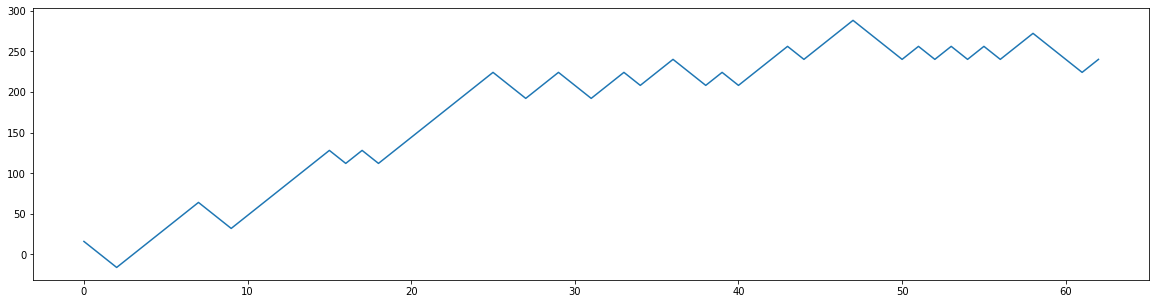

In [18]:
elo_df = game_df.drop_duplicates(subset=['Game-ID']).dropna().reset_index()
elo_df['ELO'].dropna().plot.line(figsize=(20, 5), legend=False)

## Training Results

In [19]:
model_list = [m for m in os.listdir(f'{parent}/skills/chess/data/models') if m != '.DS_Store' and '(temp)' not in m]

training_df = pd.DataFrame()
for ai_name in model_list:
    training_df = training_df.append(pd.read_csv(f'{parent}/skills/chess/data/models/{ai_name}/logs/training_log.csv'), ignore_index=False)
training_df = pd.DataFrame(training_df)
training_df = training_df.replace(0, np.nan)
training_df['Epoch'] = training_df['Epoch'].fillna(0)
training_df.head(5)

,Date,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,Cca loss,hidden loss,backbone loss,model
0,2022-05-02 09:48:37.059034,0.0,110,9.377977,2.006603,0.002453,1.003408,0.512006,3.573256,2.412716,0.008099,skills/chess/data/models/test_v11
1,2022-05-02 09:48:39.759235,1.0,110,12.078182,1.149092,0.002325,0.973215,0.199228,NaN,NaN,NaN,skills/chess/data/models/test_v11
2,2022-05-02 09:48:42.446118,2.0,110,14.765061,1.135867,0.002317,0.997439,0.323375,NaN,NaN,NaN,skills/chess/data/models/test_v11
3,2022-05-02 09:48:45.138303,3.0,110,17.457249,1.075205,0.002307,0.994095,0.222285,NaN,NaN,NaN,skills/chess/data/models/test_v11
4,2022-05-02 09:48:47.831869,4.0,110,20.150812,1.107498,0.002318,0.971590,0.230610,NaN,NaN,NaN,skills/chess/data/models/test_v11


In [20]:
training_time = {}
for g, g_df in training_df.groupby('model'):
    training_time[g] = g_df['Time'].sum()

print('Training Time')
print('-------------')
for g, t in training_time.items():
    print(f'{g} = {timedelta(seconds=t/60)}')

Training Time
-------------
skills/chess/data/models/test_v11 = 8:40:28.083923
skills/chess/data/models/test_v9 = 7:41:57.410956


In [21]:
from IPython.display import display

for m, m_df in training_df.groupby('model'):
    print(m)
    display(m_df.describe())

skills/chess/data/models/test_v11


,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,Cca loss,hidden loss,backbone loss
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,9.000000,9.000000,9.000000
mean,4.500000,226.632432,2532.006805,1.218348,0.002273,2.013537,0.146301,3.112837,1.218902,0.006322
std,2.874224,738.987716,11003.025569,0.603079,0.000100,0.862744,0.492377,0.509096,0.450872,0.001446
min,0.000000,11.000000,1.740546,0.950449,0.002057,0.622989,0.000009,2.346162,0.978476,0.004064
25%,2.000000,95.000000,182.335589,1.019185,0.002209,1.399393,0.014781,2.750850,1.027106,0.004966
50%,4.500000,170.000000,513.422021,1.043819,0.002251,1.847395,0.031040,3.110932,1.086276,0.006710
75%,7.000000,253.000000,1280.738492,1.090228,0.002317,2.585379,0.073413,3.344017,1.112369,0.007220
max,9.000000,17286.000000,94816.396234,7.171530,0.002820,4.713319,8.990321,4.042103,2.412716,0.008099


skills/chess/data/models/test_v9


,Epoch,Samples,Time,value loss,policy loss,state loss,reward loss,Cca loss,hidden loss,backbone loss
count,3820.000000,3820.000000,3820.000000,3820.000000,3820.000000,3820.000000,3.820000e+03,0.0,52.000000,52.000000
mean,4.500000,419.100524,435.352005,0.992001,0.002261,3.259361,3.589495e-02,NaN,0.874940,0.005053
std,2.872657,3113.989222,2944.002150,0.240413,0.000023,9.246119,4.238260e-02,NaN,0.107171,0.001185
min,0.000000,19.000000,0.132911,0.000113,0.002103,0.557294,8.452037e-16,NaN,0.762448,0.003200
25%,2.000000,119.000000,3.118863,1.010623,0.002256,1.426265,1.221100e-02,NaN,0.800319,0.004135
50%,4.500000,191.000000,6.946286,1.035046,0.002265,1.924530,2.410658e-02,NaN,0.828862,0.004946
75%,7.000000,282.000000,14.298206,1.064548,0.002273,2.634554,4.454464e-02,NaN,0.942003,0.005541
max,9.000000,80441.000000,37656.060323,1.563924,0.002298,143.606587,4.238868e-01,NaN,1.102792,0.008226


### Hidden Layer Loss

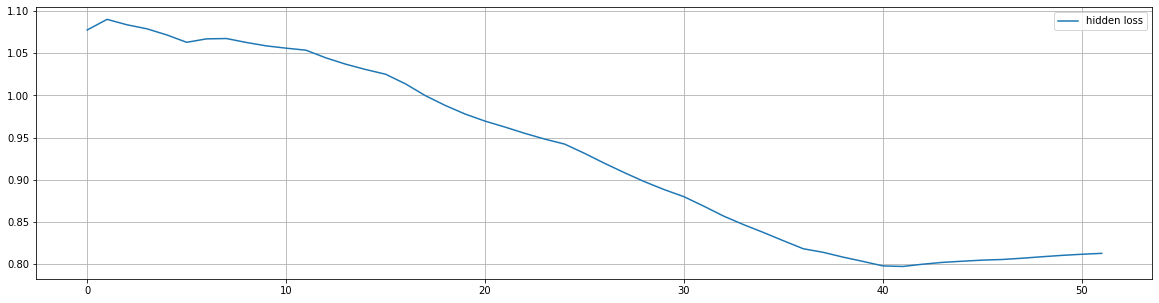

In [22]:
if 'hidden loss' in training_df:
    h_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['hidden loss','model']].dropna().reset_index()
    h_df['hidden loss'] = h_df['hidden loss'].rolling(window=25, min_periods=1).mean()
    h_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

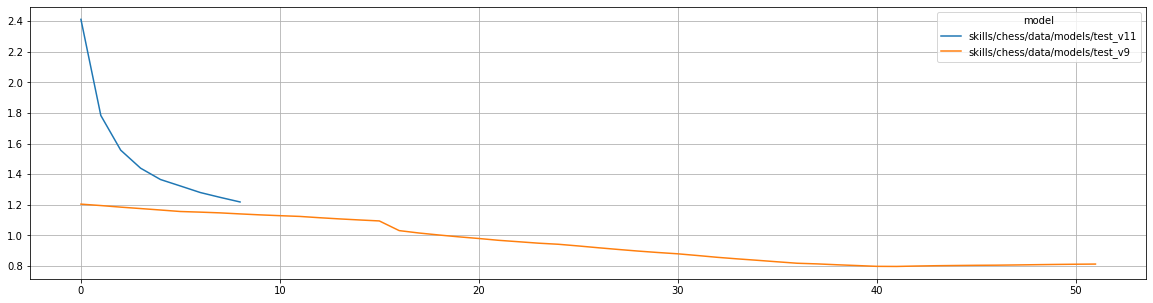

In [23]:
if 'hidden loss' in training_df:
    h_df = training_df[['hidden loss','model']].dropna().reset_index()
    h_df['hidden loss'] = h_df['hidden loss'].rolling(window=25, min_periods=1).mean()
    if len(h_df) > 0 and 'model' in h_df:
        h_df = h_df.groupby('model')['hidden loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        h_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Backbone Layer Loss

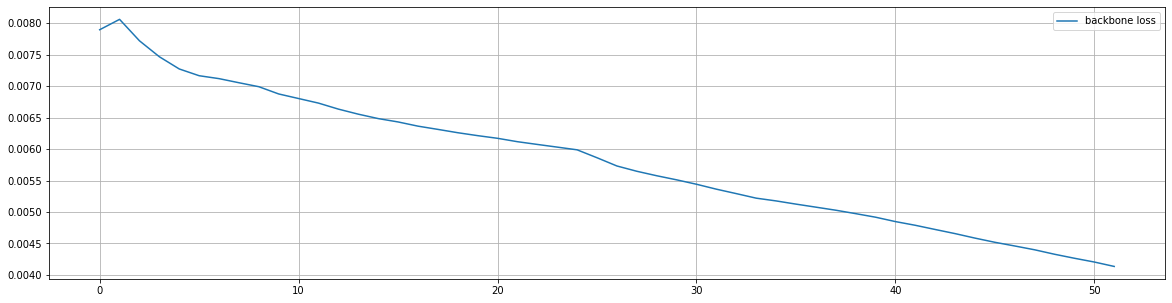

In [24]:
if 'backbone loss' in training_df:
    b_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['backbone loss','model']].dropna().reset_index()
    b_df['backbone loss'] = b_df['backbone loss'].rolling(window=25, min_periods=1).mean()
    b_df[[h for h in b_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

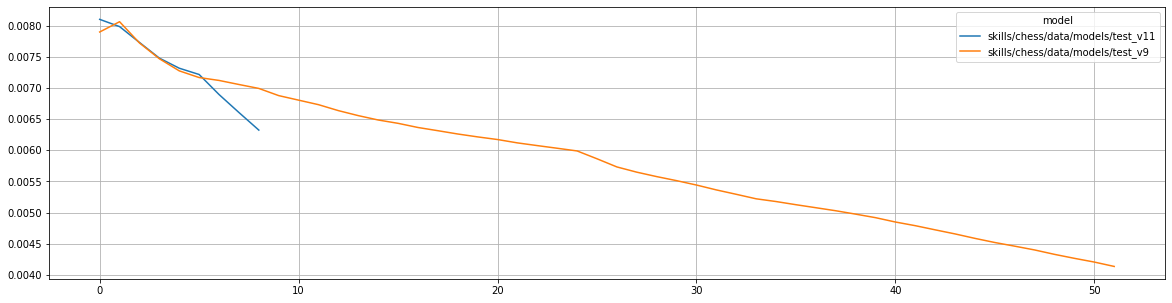

In [25]:
if 'backbone loss' in training_df:
    b_df = training_df[['backbone loss','model']].dropna().reset_index()
    #b_df['backbone loss'] = b_df['backbone loss'].rolling(window=25, min_periods=1).mean()
    b_df = b_df.groupby('model')['backbone loss'].rolling(window=25, min_periods=1).mean().reset_index()
    if len(b_df) > 0 and 'model' in b_df:
        b_df = b_df.groupby('model')['backbone loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        b_df[[h for h in b_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Chunked Cross Attention Layer Loss

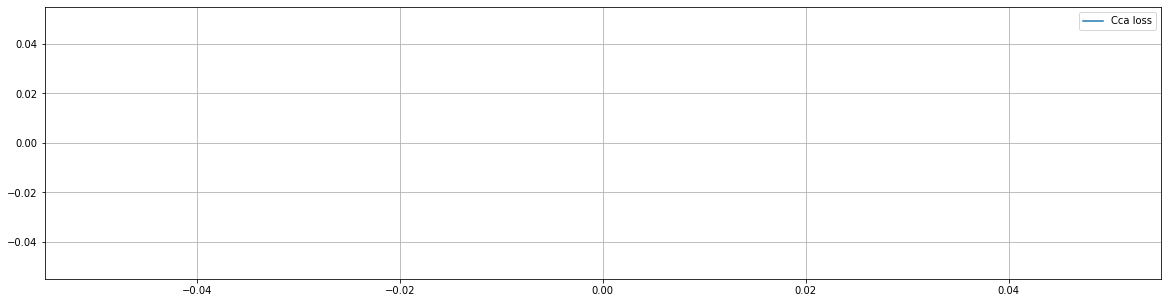

In [26]:
if 'Cca loss' in training_df:
    cca_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['Cca loss','model']].dropna().reset_index()
    cca_df['Cca loss'] = cca_df['Cca loss'].rolling(window=25, min_periods=1).mean()
    cca_df[[h for h in cca_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

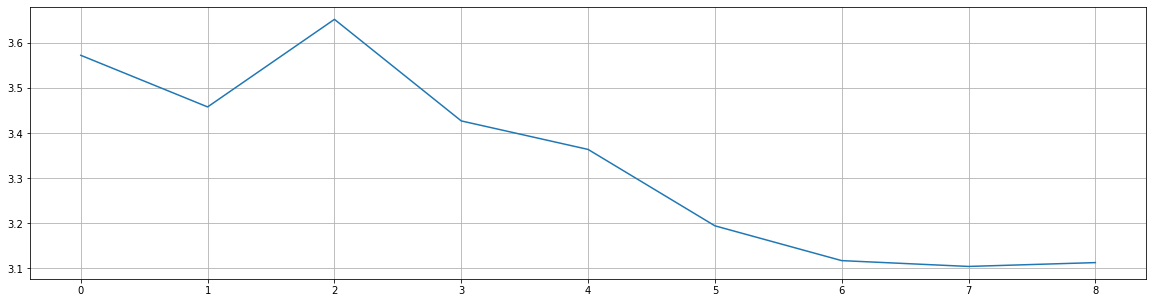

In [27]:
if 'Cca loss' in training_df:
    cca_df = training_df[['Cca loss','model']].dropna().reset_index()
    #cca_df['Cca loss'] = cca_df['Cca loss'].rolling(window=25, min_periods=1).mean()
    cca_df = cca_df.groupby('model')['Cca loss'].rolling(window=25, min_periods=1).mean().reset_index()
    if len(cca_df) > 0 and 'model' in cca_df:
        if len(cca_df['model'].unique()) > 1:
            cca_df = cca_df.groupby('model')['Cca loss'].apply(lambda x: pd.Series(x.values)).unstack().T
            cca_df[[h for h in cca_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)
        else:
            cca_df = cca_df[['Cca loss','model']]
            cca_df[[h for h in cca_df if h != 'index']].plot.line(figsize=(20, 5), legend=False, grid=True)

### Value Head Loss

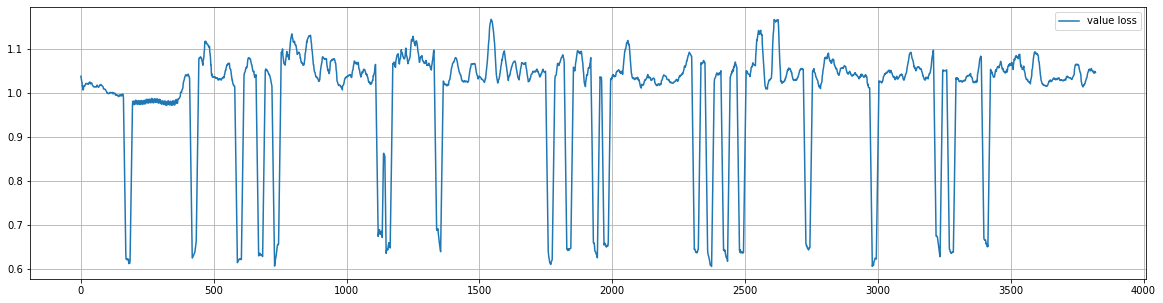

In [28]:
if 'value loss' in training_df:
    v_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['value loss','model']].dropna().reset_index()
    v_df['value loss'] = v_df['value loss'].rolling(window=25, min_periods=1).mean()
    v_df[[h for h in v_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

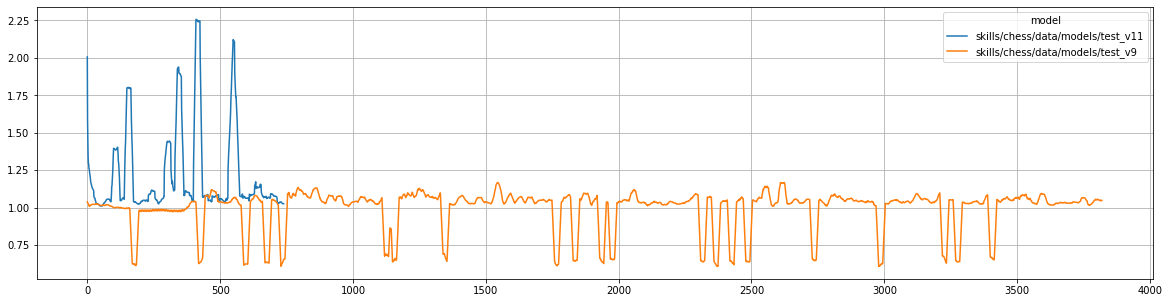

In [29]:
if 'value loss' in training_df:
    v_df = training_df[['value loss','model']].dropna().reset_index()
    #v_df['value loss'] = v_df['value loss'].rolling(window=25, min_periods=1).mean()
    v_df = v_df.groupby('model')['value loss'].rolling(window=25, min_periods=1).mean().reset_index()
    if len(v_df) > 0 and 'model' in v_df:
        v_df = v_df.groupby('model')['value loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        v_df[[h for h in v_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Policy Head Loss

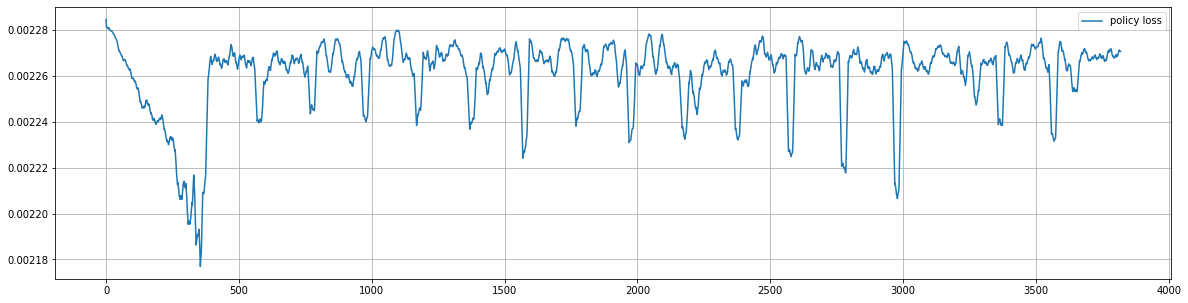

In [30]:
if 'policy loss' in training_df:
    p_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['policy loss','model']].dropna().reset_index()
    p_df['policy loss'] = p_df['policy loss'].rolling(window=25, min_periods=1).mean()
    p_df[[h for h in p_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

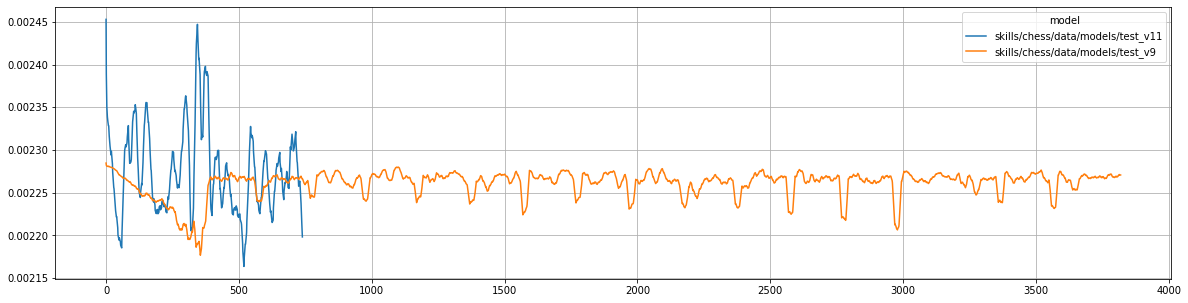

In [31]:
if 'policy loss' in training_df:
    p_df = training_df[['policy loss','model']].dropna().reset_index()
    #p_df['policy loss'] = p_df['policy loss'].rolling(window=25, min_periods=1).mean()
    p_df = p_df.groupby('model')['policy loss'].rolling(window=25, min_periods=1).mean().reset_index()
    if len(p_df) > 0 and 'model' in p_df:
        p_df = p_df.groupby('model')['policy loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        p_df[[h for h in h_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Next State Head Loss

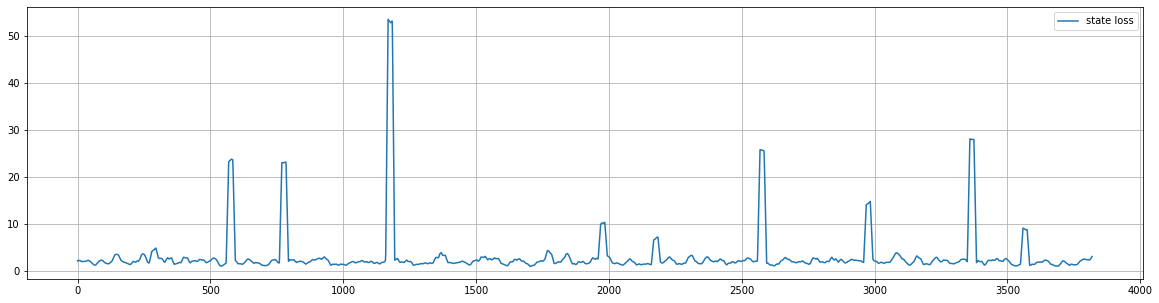

In [32]:
if 'state loss' in training_df:
    s_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['state loss','model']].dropna().reset_index()
    s_df['state loss'] = s_df['state loss'].rolling(window=25, min_periods=1).mean()
    s_df[[h for h in s_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

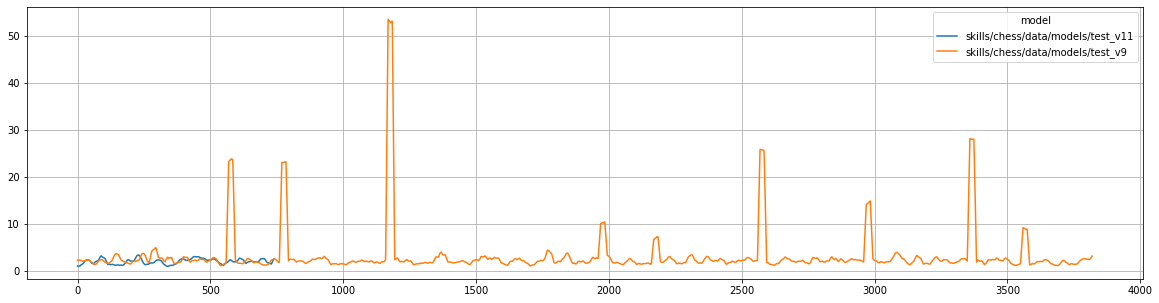

In [33]:
if 'state loss' in training_df:
    s_df = training_df[['state loss','model']].dropna().reset_index()
    #s_df['state loss'] = s_df['state loss'].dropna().rolling(window=25, min_periods=1).mean()
    s_df = s_df.groupby('model')['state loss'].rolling(window=25, min_periods=1).mean().reset_index()
    if len(s_df) > 0 and 'model' in s_df:
        s_df = s_df.groupby('model')['state loss'].apply(lambda x: pd.Series(x.values)).unstack().T
        s_df[[h for h in s_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

### Reward Head Loss

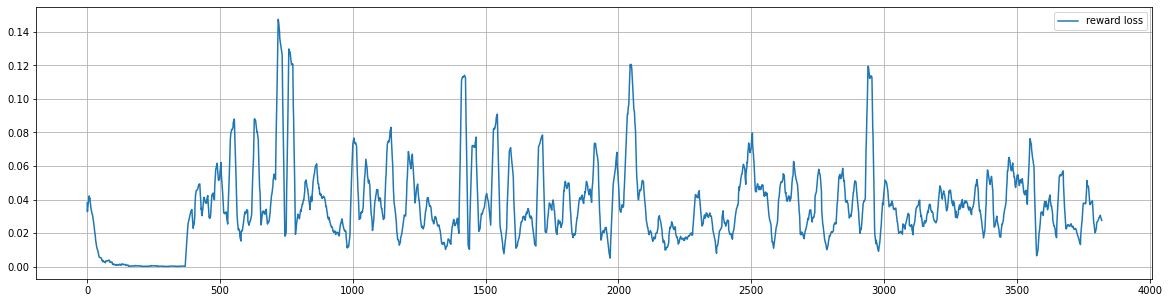

In [34]:
if 'reward loss' in training_df:
    r_df = training_df[training_df['model']==f'skills/chess/data/models/{ai}'][['reward loss','model']].dropna().reset_index()
    r_df['reward loss'] = r_df['reward loss'].rolling(window=25, min_periods=1).mean()
    r_df[[h for h in r_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)

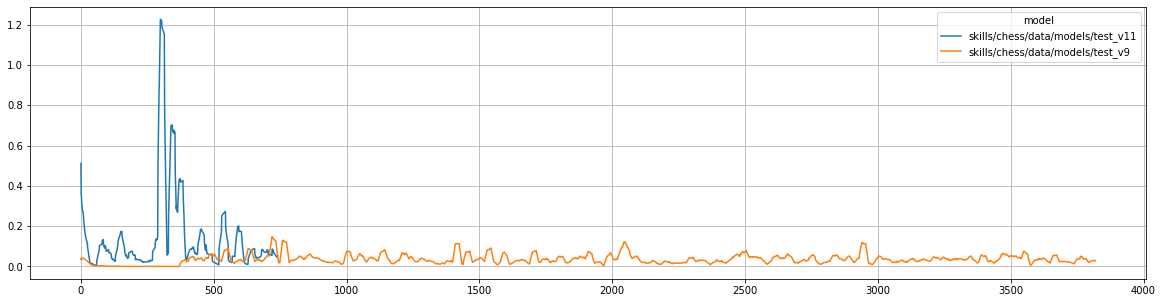

In [35]:
if 'reward loss' in training_df:
    r_df = training_df[['reward loss','model']].dropna().reset_index()
    #r_df['reward loss'] = r_df['reward loss'].dropna().rolling(window=25, min_periods=1).mean()
    r_df = r_df.groupby('model')['reward loss'].rolling(window=25, min_periods=1).mean().reset_index()
    if len(r_df) > 0 and 'model' in r_df:
        r_df = r_df.groupby('model')['reward loss'].apply(lambda x: pd.Series(x.values)).unstack().T.reset_index()
        r_df[[h for h in r_df if h != 'index']].plot.line(figsize=(20, 5), legend=True, grid=True)